First check that you have pytorch installed, instructions are here: https://pytorch.org/get-started/locally/ , prefferably do it with anaconda if you can, I think that will lead to less problems down the road if we use other libraries.

If cuda toolkit isnt available and you have an nvidia gpu try to get that too (it might be contained within anaconda pytorch package): https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html

Also note that because the dataset is large I added it to the .gitignore, you should download it from here : https://www.kaggle.com/c/cassava-leaf-disease-classification/data, and extract it into the data/ folder of the project


In [1]:
import pickle
import torch
import os 
import cv2
import json
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms

if not torch.cuda.is_available():
    print("if you have an nvidia gpu get the cuda core package")
else:
    print("cuda is available")

cuda is available


Scaling down the images and saving them to an object

In [2]:
#setting the path to the directory containing the pics
path = './data/train_images'
scaling = (80,80) #scale the images down to this resolution
output_images = './data/train_scaled'
output_filenames = './data/train_scaled_index'

if not os.path.isfile('{}.npy'.format(output_images)):
    training_data = []
    filenames = []
    for img in os.listdir(path):
        pic = cv2.imread(os.path.join(path,img))
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
        pic = cv2.resize(pic,scaling)
        training_data.append(pic)
        filenames.append(img)

    #converting the list to numpy array and saving it to a file using #numpy.save
    np.save(output_images,np.array(training_data))
    np.save(output_filenames,np.array(filenames))

    

Load mapping dictionary and the image dataset with the .csv of the labels

In [12]:
with open('./data/train.csv', newline='') as csvfile:
    labelled_dataset = dict(csv.reader(csvfile))
#print(labelled_dataset)
with open('./data/label_num_to_disease_map.json') as f:
    mapping_dict = json.load(f)


#loading the saved file once again
images = np.load('{}.npy'.format(output_images))
filenames = np.load('{}.npy'.format(output_filenames))

tensor_x = torch.Tensor(images) # transform to torch tensor
tensor_y = torch.Tensor([int(labelled_dataset[filename]) for filename in filenames])

dataset = TensorDataset(tensor_x,tensor_y) # create your datset
dataloader = DataLoader(my_dataset) # create your dataloader

def show_image(index):  
    plt.imshow(images[index].reshape(80,80,3)) # set the correct resolution here
    print(filenames[index])

Show first image from the dataset

1000910826.jpg


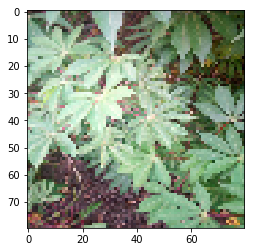

In [11]:
show_image(6)
